In [1]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt
import random
import math
from PIL import Image, ImageDraw, ImageOps
import cv2

from manga_layout import *
from frame_processor import *

In [2]:
images_dir = os.path.join(project_root, "Frame", "images", 'input')
image_files = [os.path.join(images_dir, path) for path in os.listdir(images_dir)]

#### Layout handling

In [ ]:
def create_manga_page(images, frames, width=1000, height=1400, bg_color="white"):
    """
    Takes a list of images (paths or PIL Image objects) and a list of frame coordinates,
    and resizes/crops each image to fit perfectly into its corresponding frame.
    
    Input:
        images: list of file paths or PIL Image objects (should be same length as frames)
        frames: list of (x, y, w, h) coordinates for the frames (from generate_manga_layout)
        width: width of the final manga page
        height: height of the final manga page
        bg_color: background color of the page
        
    Output:
        A PIL Image object representing the final generated manga page.
    """
    if len(images) != len(frames):
        raise ValueError(f"Number of images ({len(images)}) must match number of frames ({len(frames)})")

    # Create background page
    page = Image.new("RGB", (width, height), bg_color)
    
    for img_input, (x, y, w, h) in zip(images, frames):
        if isinstance(img_input, str):
            #if file path
            img = Image.open(img_input)
        else:
            img = img_input.copy()
            
        if img.mode != 'RGB':
            img = img.convert('RGB')
            
        # Fit the image into the target frame dimension (w, h)
        fitted_img = ImageOps.fit(img, (int(w), int(h)), method=Image.Resampling.LANCZOS)
        
        # Paste the image onto the main page at the correct coordinates
        page.paste(fitted_img, (int(x), int(y)))
        
    return page

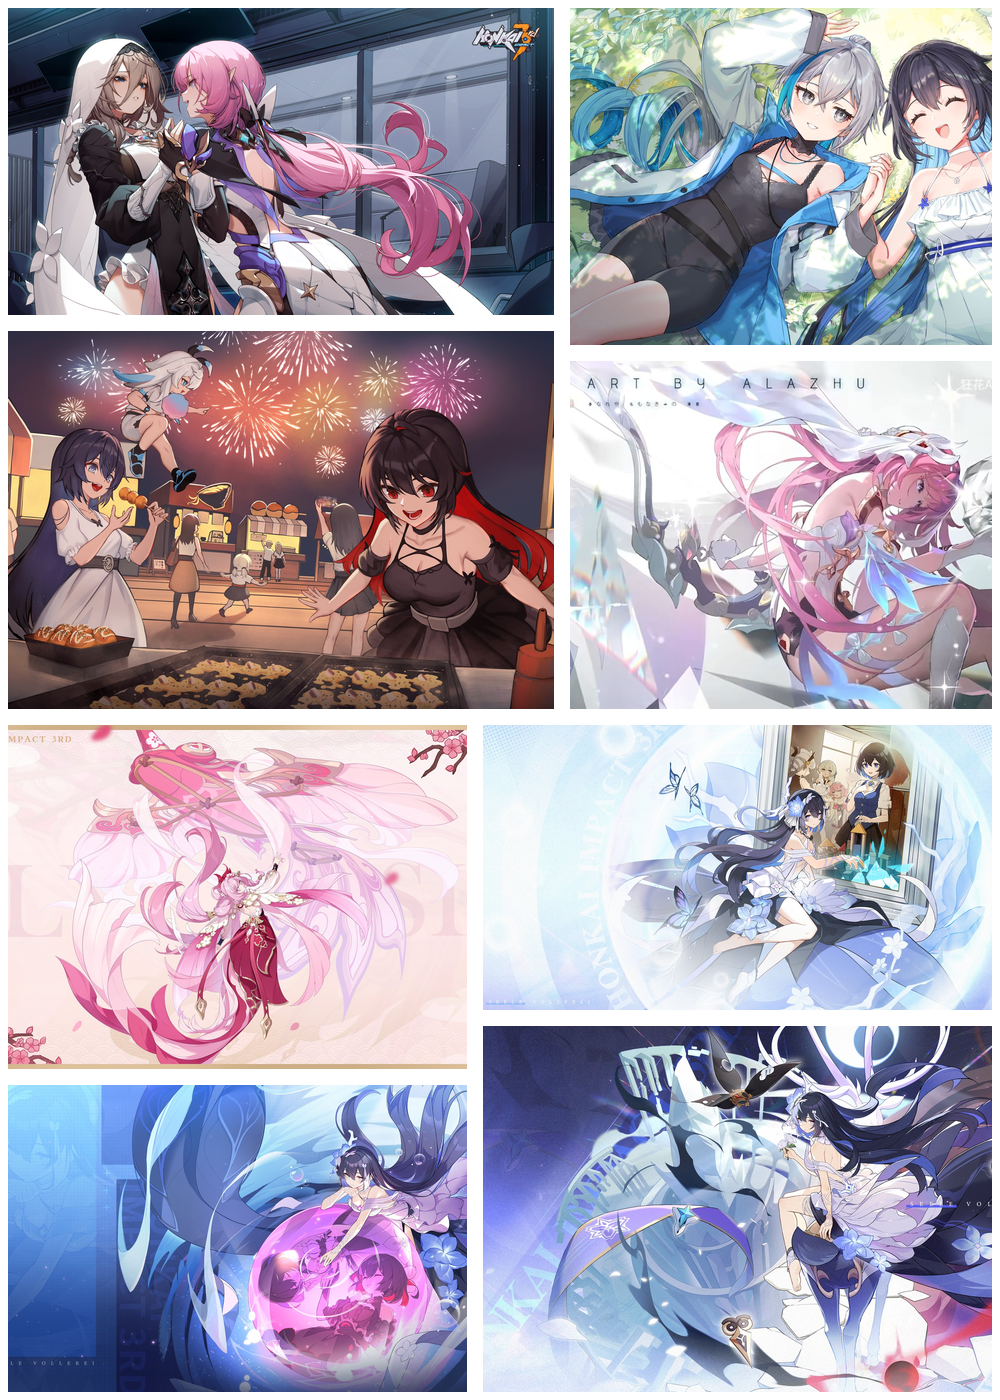

In [ ]:
images_dir = os.path.join(project_root, "Frame", "images", 'input')
image_files = [os.path.join(images_dir, path) for path in os.listdir(images_dir)[:8]]

frames = generate_manga_layout(
    width=1000, 
    height=1400, 
    num_frames=8, 
    seed=42, 
    std_dev=0.05, 
    margin=8
)

manga_page = create_manga_page(
    images=image_files, 
    frames=frames, 
    width=1000, 
    height=1400, 
    bg_color="white"
)

manga_page.save("manga_page_final_test.jpg")
manga_page

In [21]:
def draw_layout_test(width=1000, height=1400, seed=42, std_dev=0.2):
    """
    Test function to visually generate a manga page layout with basic boxes.
    """
    frames = generate_manga_layout(
        width=width, 
        height=height, 
        num_frames=8, 
        seed=seed, 
        std_dev=std_dev, 
        margin=8
    )
    
    # Create white canvas
    img = Image.new("RGB", (width, height), "white")
    draw = ImageDraw.Draw(img)
    
    # Draw gray panels
    for i, (x, y, w, h) in enumerate(frames):
        draw.rectangle([x, y, x + w, y + h], fill=(200, 200, 200), outline="black", width=3)
        
        # Draw frame number
        text_x = x + w // 2 - 10
        text_y = y + h // 2 - 10
        draw.text((text_x, text_y), str(i+1), fill="black")
        
    output_path = f"layout_test_seed_{seed}.jpg"
    img.save(output_path)
    print(f"Layout test saved to {output_path}")

In [22]:
draw_layout_test(std_dev = 0.05)

Layout test saved to layout_test_seed_42.jpg


#### Input processing

In [5]:
sample_input = image_files[-1]

In [7]:
def frame_clear(image_path, blur_threshold=100.0, brightness_threshold=50):
    """
    Checks if a frame is clear enough for processing.
    Returns a tuple: (is_clear: bool, reason: str if not clear)
    
    Args:
        image_path: Path to the image file.
        blur_threshold: Minimum variance of Laplacian to be considered "sharp".
        brightness_threshold: Minimum average brightness.
    """
    img = cv2.imread(image_path)
    if img is None:
        return False, "Failed to load image."

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Blur Detection using Variance of Laplacian
    # A sharp image will have a higher variance (more edges).
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    if laplacian_var < blur_threshold:
        return False, f"Too blurry (Score: {laplacian_var:.2f} < {blur_threshold})"

    # Brightness Check
    # Ensure the image isn't pitch black or extremely dark
    avg_brightness = np.mean(gray)
    if avg_brightness < brightness_threshold:
        return False, f"Too dark (Brightness: {avg_brightness:.2f} < {brightness_threshold})"

    return True, f"Clear (Blur Score: {laplacian_var:.2f}, Brightness: {avg_brightness:.2f})"

In [12]:
frame_clear(sample_input)

(False, 'Too blurry (Score: 41.26 < 100.0)')

In [32]:
def stylize_pipeline_a(image_path, output_path=None):
    """
    Pipeline A: Classic Black & White Manga (OpenCV Only)
    High contrast, sharp edges, grayscale.
    """
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_gray = clahe.apply(gray)

    # Edge Detection/Line Art (Adaptive Thresholding)
    # This creates a binary image (black lines on white background)
    edges = cv2.adaptiveThreshold(
        enhanced_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 9
    )

    # Blend
    # blend the line art back with the original grayscale for some depth. Or just return the harsh line art depending on preference. Let's do a harsh blend.
    result = cv2.bitwise_and(enhanced_gray, enhanced_gray, mask=edges)

    # Convert back to RGB for matplotlib/PIL rendering
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        
    return result

In [33]:
def stylize_pipeline_b(image_path, output_path=None):
    """
    Pipeline B: Anime-style Coloring / Cel-shaded (OpenCV)
    Smoothed colors with sharp edges.
    """
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Step 1: Smoothing (Bilateral Filter)
    # Bilateral filter smooths flat regions while preserving edges. We run it multiple times for a painted look.
    color = img.copy()
    for _ in range(3): 
        color = cv2.bilateralFilter(color, d=9, sigmaColor=75, sigmaSpace=75)

    # Step 2: Edge Detection
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Use median blur to reduce noise before edge detection
    gray_blur = cv2.medianBlur(gray, 7)
    edges = cv2.adaptiveThreshold(
        gray_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 2
    )
    
    # Convert edges to BGR so we can combine it with the color image
    edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    # Make the edges slightly less harsh by weighting them and just return
    result = cv2.bitwise_and(color, edges_color)

    # Convert back to RGB for matplotlib/PIL rendering
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        
    return result

In [34]:
def stylize_pipeline_c(image_path, output_path=None):
    """
    Pipeline C: Neural Style Transfer / Edge-Preserving Filter Simulation
    Since running a full deep learning model (like AnimeGAN) requires downloading weights 
    and heavy setup, this is a lightweight OpenCV simulation of a "comic book" effect 
    using Edge Preserving Filter and Stylization.
    """
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Edge Preserving Filter (maintains color better than heavy stylization)
    result = cv2.edgePreservingFilter(img, flags=1, sigma_s=40, sigma_r=0.3)

    # Convert back to RGB for matplotlib/PIL rendering
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    if output_path:
        cv2.imwrite(output_path, cv2.cvtColor(result, cv2.COLOR_RGB2BGR))
        
    return result

# --- Helper conversion for Pillow (so we can use it with create_manga_page) ---
def cv2_to_pil(cv2_image):
    """Converts a loaded OpenCV image (BGR or Gray) to a PIL Image (RGB)"""
    if len(cv2_image.shape) == 2:
        # Grayscale
        rgb_image = cv2.cvtColor(cv2_image, cv2.COLOR_GRAY2RGB)
    else:
        # BGR
        rgb_image = cv2.cvtColor(cv2_image, cv2.COLOR_BGR2RGB)
    return Image.fromarray(rgb_image)

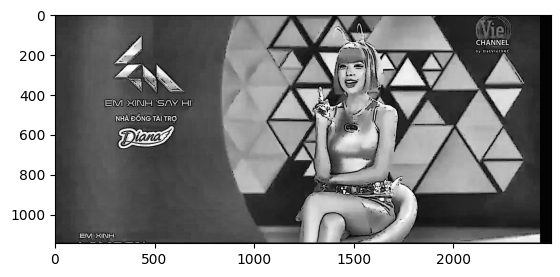

In [35]:
pipeline_a = stylize_pipeline_a(sample_input)

plt.imshow(pipeline_a)

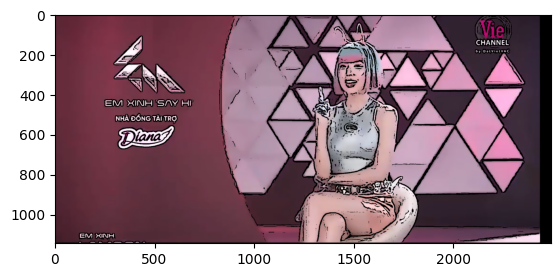

In [36]:
pipeline_b = stylize_pipeline_b(sample_input)

plt.imshow(pipeline_b)

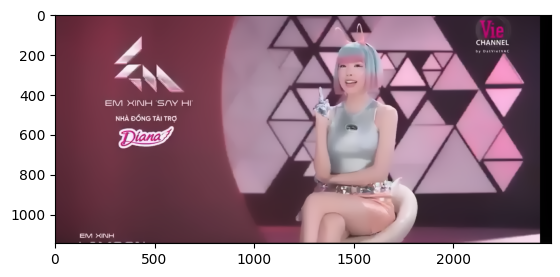

In [37]:
pipeline_c = stylize_pipeline_c(sample_input)

plt.imshow(pipeline_c)

#### Full pipeline

In [3]:
def create_manga_pipeline(image_paths, stylize_style='c', width=1000, height=1400, bg_color="white", seed=None):
    """
    Complete pipeline to process 8 original images, stylize them, and fit them into a manga layout.
    
    Args:
        image_paths: List of 8 image file paths (strings).
        stylize_style: The stylization chosen ('a', 'b', or 'c').
        width: Width of the final manga page.
        height: Height of the final manga page.
        bg_color: Background color of the manga page.
        seed: Random seed for layout generation.
        
    Returns:
        A PIL Image representing the generated manga page.
    """
    if len(image_paths) != 8:
        raise ValueError(f"Pipeline requires exactly 8 images, but {len(image_paths)} were provided.")
        
    processed_images = []
    
    for path in image_paths:
        # Quality checking step (Log a warning if image is blurry or dark)
        is_clear, reason = frame_clear(path)
        if not is_clear:
            print(f"Warning - Frame quality issue for {os.path.basename(path)}: {reason}")
            
        # Stylization step
        if stylize_style == 'a':
            processed_cv2 = stylize_pipeline_a(path)
        elif stylize_style == 'b':
            processed_cv2 = stylize_pipeline_b(path)
        elif stylize_style == 'c':
            processed_cv2 = stylize_pipeline_c(path)
        else:
            raise ValueError("Invalid stylize_style. Must be 'a', 'b', or 'c'.")
            
        if processed_cv2 is None:
            raise FileNotFoundError(f"Failed to load or process image: {path}")
            
        # Convert to PIL Image for the layout step
        pil_img = cv2_to_pil(processed_cv2)
        processed_images.append(pil_img)

    # 2. Generate layout frames
    # generate_manga_layout creates 8 frames by default
    frames = generate_manga_layout(
        width=width, 
        height=height, 
        num_frames=len(image_paths), 
        seed=seed,
        margin=8,
        std_dev=0.05
    )
    
    # 3. Fit images into layout to create the final manga page
    manga_page = create_manga_page(
        images=processed_images, 
        frames=frames, 
        width=width, 
        height=height, 
        bg_color=bg_color
    )
    
    return manga_page


In [6]:
manga_page = create_manga_pipeline(image_files[:8], seed=1, stylize_style='b')

In [7]:
manga_page.save('sample2.png')